In [26]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [27]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [28]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
model_1 = load_model('D:\\Models\\model_inception.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='Inception_V3')
model_2 = load_model('D:\\Models\\model_MobileNet_V2.h5')
model_2 = Model(inputs=model_2.inputs,
             outputs=model_2.outputs,
              name='MobileNet_V2')
model_3 = load_model('D:\\Models\\model_resnet50.h5')
model_3 = Model(inputs=model_3.inputs,
             outputs=model_3.outputs,
              name='Resnet_50')
model_4 = load_model('D:\\Models\\model_Vgg19.h5')
model_4 = Model(inputs=model_4.inputs,
             outputs=model_4.outputs,
              name='Vgg_19')
models = [model_1, model_2, model_3, model_4]



In [31]:
#weights = [0.7, 0.9]

#w = np.array([0.7, 0.9])
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]

#ensemble = VotingClassifier(estimators=models, weights=w, voting='soft')
#ensemble_output = Average()(model_outputs)
#ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [32]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, w3, w4,**kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.w4 = w4
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'w1': self.w1,
            'w2': self.w2,
            'w3': self.w3,
            'w4': self.w4,
        })
        return config
        
    def call(self,inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] + self.w3 * inputs[2] + self.w4 * inputs[3]

In [33]:
import tensorflow as tf
ensemble_output = WeightedAverageLayer(0.3, 0.6, 0.1, 0.9)(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [34]:
ensemble_model.compile(optimizer='adam',loss=tf.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [35]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Inception_V3 (Functional)      (None, 4)            22007588    ['input_2[0][0]']                
                                                                                                  
 MobileNet_V2 (Functional)      (None, 4)            2508868     ['input_2[0][0]']                
                                                                                                  
 Resnet_50 (Functional)         (None, 4)            23989124    ['input_2[0][0]']         

In [36]:
IMAGE_SIZE = [224, 224]

train_path = 'D:\\Dataset\\train'
valid_path = 'D:\\Dataset\\test'

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [38]:
training_set = train_datagen.flow_from_directory('D:\\Dataset\\train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 12758 images belonging to 4 classes.


In [39]:
test_set = test_datagen.flow_from_directory('D:\\Dataset\\test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 3026 images belonging to 4 classes.


In [40]:
r = ensemble_model.fit(
     training_set,
     validation_data=test_set,
     epochs=15
)

Epoch 1/15
399/399 [==============================] - 5461s 14s/step - loss: 0.1340 - accuracy: 0.9717 - val_loss: 0.3184 - val_accuracy: 0.9392
Epoch 2/15
399/399 [==============================] - 5118s 13s/step - loss: 0.1907 - accuracy: 0.9640 - val_loss: 0.2987 - val_accuracy: 0.9313
Epoch 3/15
399/399 [==============================] - 5157s 13s/step - loss: 0.1974 - accuracy: 0.9602 - val_loss: 0.3141 - val_accuracy: 0.9488
Epoch 4/15
399/399 [==============================] - 5165s 13s/step - loss: 0.1803 - accuracy: 0.9675 - val_loss: 0.3685 - val_accuracy: 0.9323
Epoch 5/15
399/399 [==============================] - 5117s 13s/step - loss: 0.1711 - accuracy: 0.9696 - val_loss: 0.2893 - val_accuracy: 0.9475
Epoch 6/15
399/399 [==============================] - 5155s 13s/step - loss: 0.1936 - accuracy: 0.9721 - val_loss: 0.3202 - val_accuracy: 0.9399
Epoch 7/15
399/399 [==============================] - 5123s 13s/step - loss: 0.1795 - accuracy: 0.9683 - val_loss: 0.2993 - val_ac

In [41]:
import tensorflow as tf
tf.__version__

'2.10.0'

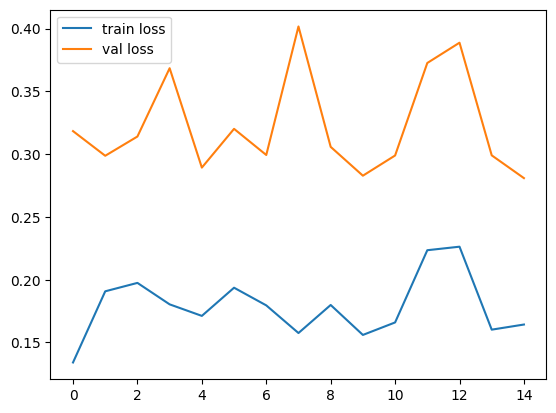

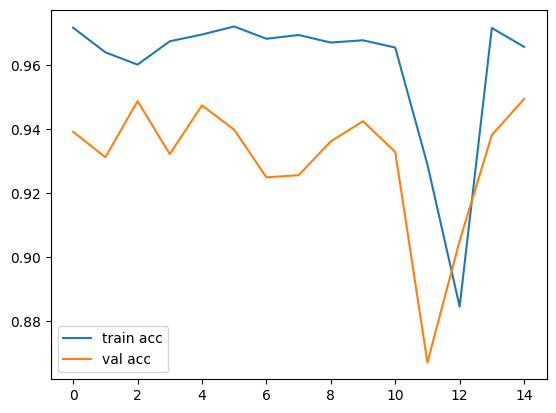

<Figure size 640x480 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

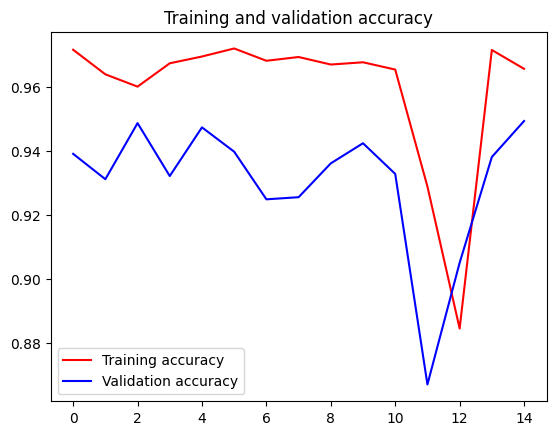

<Figure size 640x480 with 0 Axes>

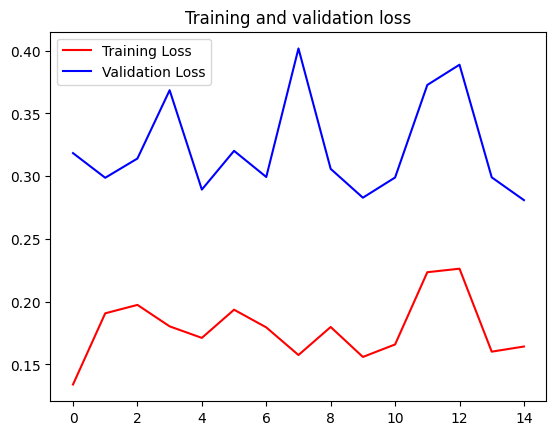

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()
plt.savefig('Accuracy_Plot')

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.show()
plt.savefig('Loss_Plot')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg19 import VGG19
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Evaluate the model on test data
scores = model.evaluate(test_set, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Make predictions on test data
y_pred = model.predict(test_set)
y_true = test_set.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, test_set.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_set.class_indices.keys())
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Print classification report
report = classification_report(y_true, np.argmax(y_pred, axis=1), target_names=test_set.class_indices.keys())
print(report)




In [44]:
# save it as a h5 file


from tensorflow.keras.models import load_model
#tf.keras.models.save_model
ensemble_model.save('C:\\Users\\Kunal Adsule\\Desktop\\Jupyter Notebooks\\Ensemble_Weighted Average')

#tf.saved_model.save(ensemble_model, 'C:\\Users\\Kunal Adsule\\Desktop\\Jupyter Notebooks\\Model_Weight')

INFO:tensorflow:Assets written to: C:\Users\Kunal Adsule\Desktop\Jupyter Notebooks\Ensemble_Weighted Average\assets


INFO:tensorflow:Assets written to: C:\Users\Kunal Adsule\Desktop\Jupyter Notebooks\Ensemble_Weighted Average\assets


In [45]:
ensemble_model.save('Ensemble_Weighted Average.h5')

ValueError: Unable to create dataset (name already exists)

In [46]:
ensemble_model.save('ensemble_model.hdf5')#, save_format='tf')  # Save the model as a SavedModel format

ValueError: Unable to create dataset (name already exists)

In [47]:
ensemble_model.evaluate(test_set)

95/95 [==============================] - 1080s 11s/step - loss: 0.2809 - accuracy: 0.9494


[0.28090938925743103, 0.949438214302063]